In [47]:
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


url = 'https://apis.data.go.kr/1480523/WaterQualityService/getWaterMeasuringList'
key = 'a6TS+sDQ+cPdv92zVxHz2EI1fV2sWy5kXdu9x/+QasyDSIU3105j6dts2lS2dnW7Y/YFXSw32QdOqyagGTCI8Q=='

In [48]:
# 2. 주소에 있던 파라미터 그대로 설정
params = {
    'serviceKey': key,
    'pageNo': '1',
    'numOfRows': '3000',
    'resultType': 'json',
    'ptNoList': '2022A30,2022A10', # 측정소 코드
    'wmyrList': '2021,2022,2023,2024,2025',      # 연도
    'wmodList': '01,02,03,04,05,06,07,08,09,10,11,12'        # 월(01, 02, 03월)
}

try:
    # 3. API 요청
    response = requests.get(url, params=params, verify=True) # https 대응
    
    if response.status_code == 200:
        data = response.json()
        
        # 4. 데이터 추출 (구조: getWaterMeasuringList -> item)
        items = data.get('getWaterMeasuringList', {}).get('item', [])
        
        if items:
            df = pd.DataFrame(items)
            # df.set_index('ROWNO',inplace=True)

            # 5. 주요 수질 항목 한글 이름으로 변경 
            rename_map = {
                'PT_NM': '총량지점명',
                'WMCYMD': '일자',
                'ITEM_TEMP': '수온', # 단위 : ℃
                'ITEM_PH': '수소이온농도(ph)',
                'ITEM_EC': '전기전도도(EC)',    # 단위 : μS/㎝
                'ITEM_DOC': '용존산소(DO)', # 단위 : ㎎/L
                'ITEM_BOD': 'BOD',  # 단위 : ㎎/L
                'ITEM_COD': 'COD',  # 단위 : ㎎/L
                'ITEM_SS': '부유물질',  # 단위 : ㎎/L
                'ITEM_TN': '총질소(T-N)',   # 단위 : ㎎/L
                'ITEM_TP': '총인(T-P)', # 단위 : ㎎/L
                'ITEM_TOC': '총유기탄소(TOC)',  # 단위 : ㎎/L
                'ITEM_AMNT': '유량',    # 단위 : ㎥/s
                'ITEM_CLOA': '클로로필-a'
            }
            
            # 2. 필요한 컬럼만 추출하여 새 DF 생성
            waterDF = df[list(rename_map.keys())].copy()
            waterDF.rename(columns=rename_map, inplace=True)

            # 3. 데이터 타입 숫자형으로 변환 (연산 가능하게)
            num_cols = ['수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD', 'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량','클로로필-a']
            waterDF[num_cols] = waterDF[num_cols].apply(pd.to_numeric, errors='coerce')

            # # 4. 날짜 데이터 형식 변환 (YYYYMMDD -> datetime)
            waterDF['일자'] = pd.to_datetime(waterDF['일자'], errors='coerce')

            print("--- 분석 준비 완료: 핵심 수질 지표 ---")
            print(waterDF.head())
        else:
            print("응답은 성공했으나 데이터가 없습니다.")
    else:
        print(f"API 요청 실패: {response.status_code}")

except Exception as e:
    print(f"오류 발생: {e}")

--- 분석 준비 완료: 핵심 수질 지표 ---
  총량지점명         일자   수온  수소이온농도(ph)  전기전도도(EC)  용존산소(DO)  BOD  COD  부유물질  \
0    물금 2021-01-04  4.6         7.5      437.0      13.1  1.7  5.1   2.4   
1    물금 2021-01-11  2.8         7.3      461.0      14.3  2.0  5.4   4.0   
2    물금 2021-01-26  5.1         7.2      470.0      15.6  2.1  6.0   7.6   
3    물금 2021-01-18  3.1         7.3      463.0      15.2  2.2  5.9   6.4   
4    물금 2021-02-16  6.6         8.4      451.0      12.1  2.8  6.6  12.4   

   총질소(T-N)  총인(T-P)  총유기탄소(TOC)      유량  클로로필-a  
0     3.223    0.025         3.8  29.555    12.4  
1     3.268    0.031         4.0  28.599    19.4  
2     3.416    0.026         4.6  74.897    47.3  
3     3.327    0.032         4.4  47.190    33.2  
4     3.489    0.027         5.0  72.735    50.4  


In [49]:
# ====== 기본 정리 ======
waterDF = waterDF.dropna(subset=['일자']).sort_values('일자').copy()

# 연/월/계절/로그 변수
waterDF['연도'] = waterDF['일자'].dt.year
waterDF['월'] = waterDF['일자'].dt.month
waterDF['계절구분'] = np.where(waterDF['월'].isin([6,7,8,9]), '여름', '비여름')
waterDF['log_chl'] = np.log1p(waterDF['클로로필-a'])

# 결측률 확인 1회만
display(waterDF.isna().mean().sort_values(ascending=False).head(10))


총질소(T-N)      0.004926
COD           0.004926
클로로필-a        0.004926
유량            0.004926
총유기탄소(TOC)    0.004926
총인(T-P)       0.004926
부유물질          0.004926
log_chl       0.004926
BOD           0.004926
용존산소(DO)      0.004926
dtype: float64

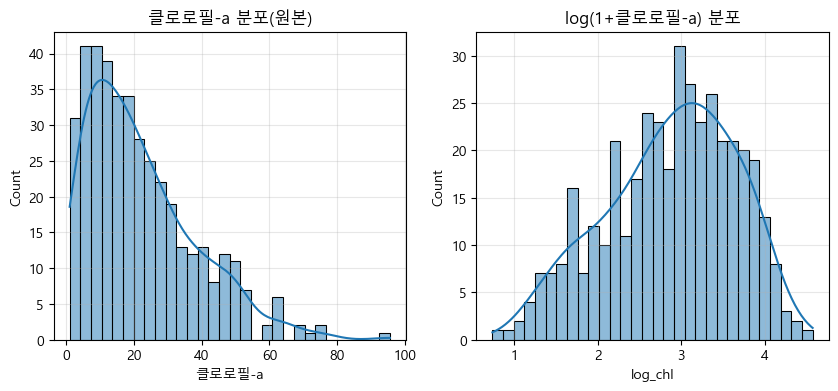

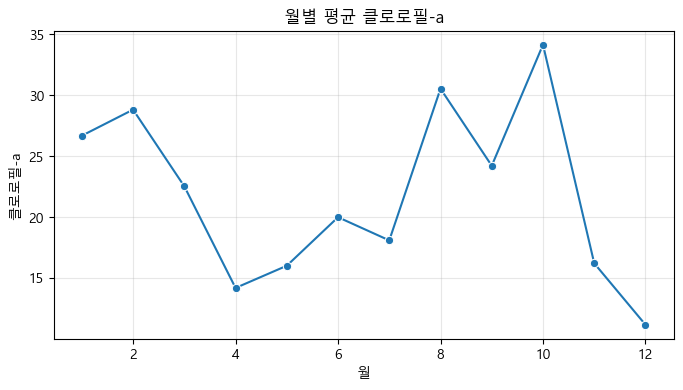

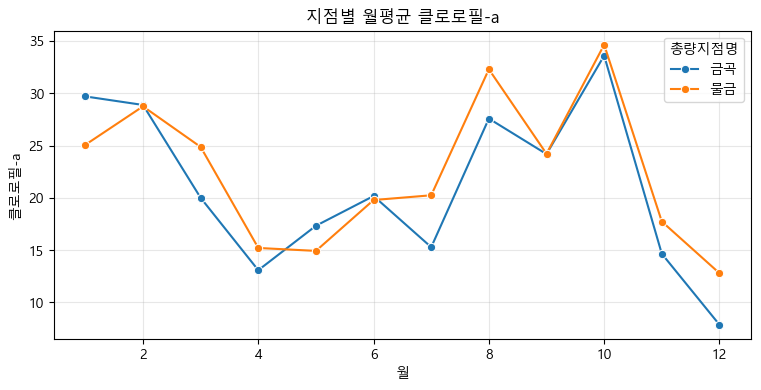

In [50]:
# 1) 클로로필-a 분포(원본/로그)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sb.histplot(waterDF['클로로필-a'], bins=30, kde=True)
plt.title('클로로필-a 분포(원본)'); plt.grid(alpha=0.3)

plt.subplot(1,2,2)
sb.histplot(waterDF['log_chl'], bins=30, kde=True)
plt.title('log(1+클로로필-a) 분포'); plt.grid(alpha=0.3)
plt.show()

# 2) 월별 평균(계절성)
monthly_mean = waterDF.groupby('월')['클로로필-a'].mean().reset_index()
plt.figure(figsize=(8,4))
sb.lineplot(data=monthly_mean, x='월', y='클로로필-a', marker='o')
plt.title('월별 평균 클로로필-a'); plt.grid(alpha=0.3)
plt.show()

# 3) 지점별 월평균(금곡/물금 비교)
site_month = waterDF.groupby(['총량지점명','월'])['클로로필-a'].mean().reset_index()
plt.figure(figsize=(9,4))
sb.lineplot(data=site_month, x='월', y='클로로필-a', hue='총량지점명', marker='o')
plt.title('지점별 월평균 클로로필-a'); plt.grid(alpha=0.3)
plt.show()


C:\Users\Dell3571\AppData\Local\Temp\ipykernel_25768\3983964206.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(


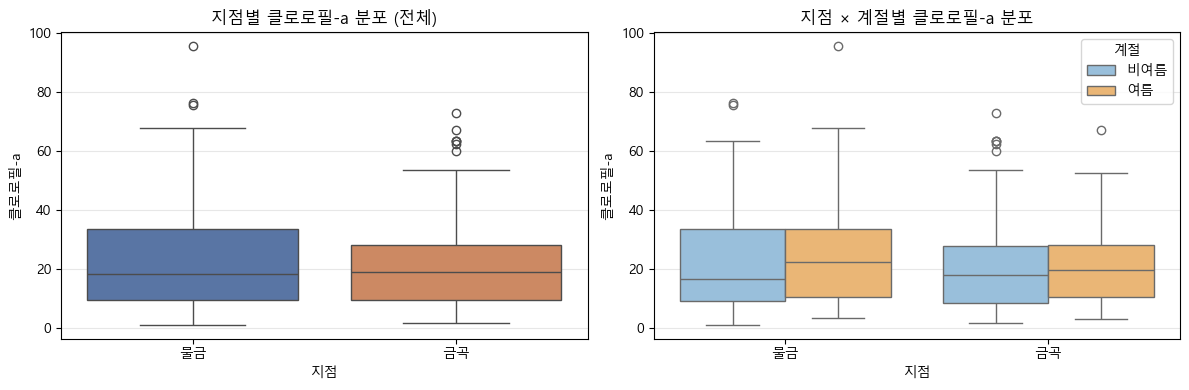

In [51]:
plt.figure(figsize=(12,4))

# 1️⃣ 지점별 클로로필-a 분포 (전체)
plt.subplot(1, 2, 1)
sb.boxplot(
    data=waterDF,
    x='총량지점명',
    y='클로로필-a',
    palette={'물금': '#4C72B0', '금곡': '#DD8452'}
)
plt.title('지점별 클로로필-a 분포 (전체)')
plt.xlabel('지점')
plt.ylabel('클로로필-a')
plt.grid(axis='y', alpha=0.3)

# 2️⃣ 지점 × 계절 박스플롯
plt.subplot(1, 2, 2)
sb.boxplot(
    data=waterDF,
    x='총량지점명',
    y='클로로필-a',
    hue='계절구분',
    palette={'비여름': '#8EC1E6', '여름': '#FDB863'}
)
plt.title('지점 × 계절별 클로로필-a 분포')
plt.xlabel('지점')
plt.ylabel('클로로필-a')
plt.legend(title='계절')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [52]:
# 위험도 기준(고정)
# - 저위험 : 15 미만
# - 중위험 : 15 이상 25 미만
# - 고위험 : 25 이상
bins = [-np.inf, 12, 30, np.inf]
labels = ['저위험','중위험','고위험']
waterDF['위험도'] = pd.cut(waterDF['클로로필-a'], bins=bins, labels=labels)

print("전체 분포\n" ,waterDF['위험도'].value_counts().sort_index())
print("\n계절별 분포(%)\n", pd.crosstab(waterDF['계절구분'], waterDF['위험도'], normalize='index')*100)


전체 분포
 위험도
저위험    129
중위험    168
고위험    107
Name: count, dtype: int64

계절별 분포(%)
 위험도         저위험        중위험        고위험
계절구분                                 
비여름   33.712121  38.636364  27.651515
여름    28.571429  47.142857  24.285714


In [53]:
# 모델링 데이터 구성
modelDF = waterDF.dropna(subset=['위험도']).copy()

feature_cols = [
    '총량지점명','월',
    '수온','유량',
    '총질소(T-N)','총인(T-P)',
    'BOD','COD','총유기탄소(TOC)'
]

X = modelDF[feature_cols]
y = modelDF['위험도'].astype(str)

# 시계열 기반 학습 / 검증 분리
test_year = modelDF['연도'].max()  # 최신연도(2025)
train_idx = modelDF['연도'] < test_year
test_idx  = modelDF['연도'] == test_year

# 데이터 분할
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# 분할 결과 검증
print("Train 연도:", sorted(modelDF.loc[train_idx,'연도'].unique())) # .unique() 중복 제거
print("Test 연도 :", sorted(modelDF.loc[test_idx,'연도'].unique()))
print("Train:", X_train.shape, "Test:", X_test.shape)
print("Test 분포:\n", y_test.value_counts())


Train 연도: [2021, 2022, 2023, 2024]
Test 연도 : [2025]
Train: (341, 9) Test: (63, 9)
Test 분포:
 위험도
중위험    30
고위험    17
저위험    16
Name: count, dtype: int64


In [54]:
num_cols = ['월', '수온', '유량', '총질소(T-N)', '총인(T-P)', 'BOD', 'COD', '총유기탄소(TOC)']
cat_cols = ['총량지점명']

# LogisticRegression: 수치=결측치 대체 + 표준화 / 범주=원핫
preprocess_lr = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# RandomForest: 수치=결측치 대체만 / 범주=원핫
preprocess_rf = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


[LogisticRegression]
               precision    recall  f1-score   support

         고위험       0.69      0.53      0.60        17
         저위험       0.54      0.94      0.68        16
         중위험       0.59      0.43      0.50        30

    accuracy                           0.59        63
   macro avg       0.61      0.63      0.59        63
weighted avg       0.60      0.59      0.57        63



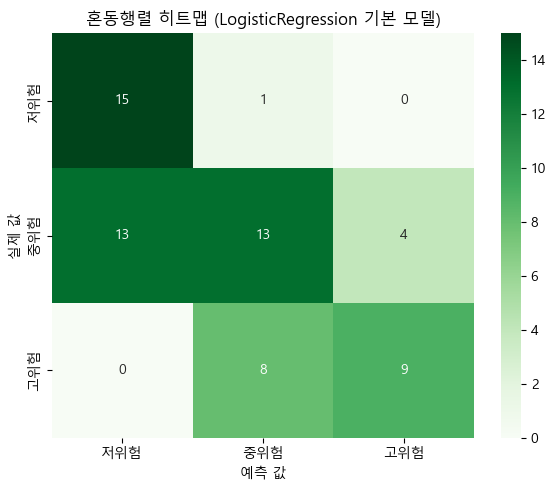

In [55]:
logi = LogisticRegression(
    max_iter=2000,
    class_weight='balanced'   # 클래스 불균형 보정
)

logi_pipe = Pipeline([
    ('preprocess', preprocess_lr),
    ('model', logi)
])

logi_pipe.fit(X_train, y_train)
pred_logi = logi_pipe.predict(X_test)

print("[LogisticRegression]\n", classification_report(y_test, pred_logi))

cm_logi = confusion_matrix(y_test, pred_logi, labels=['저위험', '중위험', '고위험'])
plt.figure(figsize=(6, 5))
sb.heatmap(
    cm_logi,
    annot=True, fmt='d',
    cmap='Greens',
    xticklabels=['저위험', '중위험', '고위험'],
    yticklabels=['저위험', '중위험', '고위험']
)
plt.title('혼동행렬 히트맵 (LogisticRegression 기본 모델)')
plt.xlabel('예측 값')
plt.ylabel('실제 값')
plt.tight_layout()
plt.show()

[RandomForest]
               precision    recall  f1-score   support

         고위험       0.71      0.29      0.42        17
         저위험       0.59      0.81      0.68        16
         중위험       0.59      0.67      0.62        30

    accuracy                           0.60        63
   macro avg       0.63      0.59      0.58        63
weighted avg       0.62      0.60      0.58        63

[[13  2  1]
 [ 9 20  1]
 [ 0 12  5]]


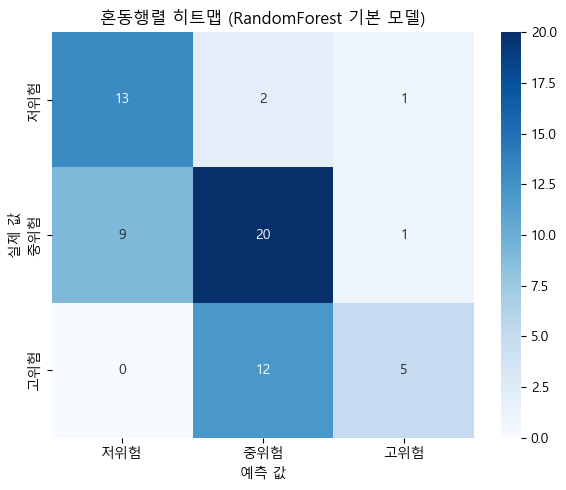

In [56]:
# RandomForest 학습/평가 + 히트맵
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    class_weight='balanced_subsample'
)

rf_pipe = Pipeline([
    ('preprocess', preprocess_rf),
    ('model', rf)
])

rf_pipe.fit(X_train, y_train)
pred_rf = rf_pipe.predict(X_test)

print("[RandomForest]\n", classification_report(y_test, pred_rf))

# 혼동행렬(라벨 순서 고정) - 출력 + 히트맵에 동일 행렬 사용
cm_rf = confusion_matrix(y_test, pred_rf, labels=['저위험', '중위험', '고위험'])
print(cm_rf)

plt.figure(figsize=(6, 5))
sb.heatmap(
    cm_rf,
    annot=True, fmt='d',
    cmap='Blues',
    xticklabels=['저위험', '중위험', '고위험'],
    yticklabels=['저위험', '중위험', '고위험']
)
plt.title('혼동행렬 히트맵 (RandomForest 기본 모델)')
plt.xlabel('예측 값')
plt.ylabel('실제 값')
plt.tight_layout()
plt.show()

In [57]:
# 고위험 클래스 중심 성능 분석
# 고위험 확률 추출
proba = rf_pipe.predict_proba(X_test)
classes = list(rf_pipe.named_steps['model'].classes_)
high_idx = classes.index('고위험')
p_high = proba[:, high_idx]

# 고위험만 1로 만든 이진 정답(튜닝용)
y_true = (y_test == '고위험').astype(int)

def pr_at(th):
    """임계값(th) 기준으로 고위험(1) 판정 시 Precision/Recall 계산"""
    y_pred = (p_high >= th).astype(int)
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    return precision, recall, tp, fp, fn

thresholds = np.arange(0.10, 0.91, 0.05)
thr_df = pd.DataFrame(
    [[th, *pr_at(th)] for th in thresholds],
    columns=['threshold', 'precision', 'recall', 'TP', 'FP', 'FN']
)
thr_df


,threshold,precision,recall,TP,FP,FN
0,0.10,0.444444,0.941176,16,20,1
1,0.15,0.500000,0.882353,15,15,2
2,0.20,0.636364,0.823529,14,8,3
3,0.25,0.722222,0.764706,13,5,4
4,0.30,0.687500,0.647059,11,5,6
5,0.35,0.833333,0.588235,10,2,7
6,0.40,0.818182,0.529412,9,2,8
7,0.45,0.833333,0.294118,5,1,12
8,0.50,0.800000,0.235294,4,1,13
9,0.55,0.750000,0.176471,3,1,14


[Final RF] threshold=0.35
               precision    recall  f1-score   support

         고위험       0.83      0.59      0.69        17
         저위험       0.59      0.81      0.68        16
         중위험       0.69      0.67      0.68        30

    accuracy                           0.68        63
   macro avg       0.70      0.69      0.68        63
weighted avg       0.70      0.68      0.68        63



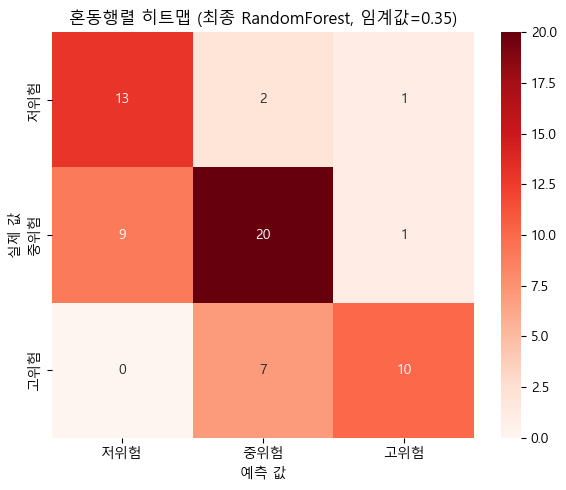

In [58]:
# 최종 임계값(고위험 우선 탐지 목적이면 낮추고, 오탐 줄이려면 올림)
final_threshold = 0.35

# 중복 제거 포인트: base_pred는 pred_rf 재사용(예측 2번 하지 않음)
base_pred = pred_rf
y_pred_final = np.where(p_high >= final_threshold, '고위험', base_pred)

print(f"[Final RF] threshold={final_threshold}\n", classification_report(y_test, y_pred_final))

cm_final = confusion_matrix(y_test, y_pred_final, labels=['저위험', '중위험', '고위험'])
plt.figure(figsize=(6, 5))
sb.heatmap(
    cm_final,
    annot=True, fmt='d',
    cmap='Reds',
    xticklabels=['저위험', '중위험', '고위험'],
    yticklabels=['저위험', '중위험', '고위험']
)
plt.title(f'혼동행렬 히트맵 (최종 RandomForest, 임계값={final_threshold})')
plt.xlabel('예측 값')
plt.ylabel('실제 값')
plt.tight_layout()
plt.show()

### 금곡/물금 지점 분리

In [59]:
modelDF = waterDF.dropna(subset=['위험도']).copy()

# 지점 값 확인(금곡/물금이 정확히 들어와 있는지)
modelDF['총량지점명'].value_counts()

총량지점명
물금    225
금곡    179
Name: count, dtype: int64

In [60]:
def run_site_model(site_name, modelDF, test_year, final_threshold=0.35):
    print("\n" + "="*90)
    print(f"[지점별 모델링] {site_name} / test_year={test_year}")
    print("="*90)

    # 1) 지점별 분리
    siteDF = modelDF[modelDF['총량지점명'] == site_name].copy()

    # 2) 시계열 분리(연도)
    train_idx = siteDF['연도'] < test_year
    test_idx  = siteDF['연도'] == test_year

    print("Train n:", train_idx.sum(), "Test n:", test_idx.sum())
    if train_idx.sum() == 0 or test_idx.sum() == 0:
        print("⚠️ 학습/테스트 데이터가 부족합니다. (해당 지점에 test_year 데이터가 없을 수 있음)")
        return None

    # 3) 피처(지점별 모델이므로 '총량지점명' 제거)
    feature_cols = [
        '월',
        '수온','유량',
        '총질소(T-N)','총인(T-P)',
        'BOD','COD','총유기탄소(TOC)'
    ]

    X = siteDF[feature_cols]
    y = siteDF['위험도'].astype(str)

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print("Train 연도:", sorted(siteDF.loc[train_idx,'연도'].unique()))
    print("Test 연도 :", sorted(siteDF.loc[test_idx,'연도'].unique()))
    print("Test 분포:\n", y_test.value_counts())

    # 4) 전처리(수치형만)
    num_cols = feature_cols

    preprocess_lr = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols)
    ])

    preprocess_rf = ColumnTransformer([
        ('num', SimpleImputer(strategy='median'), num_cols)
    ])

    # 5) LogisticRegression
    logi = LogisticRegression(max_iter=2000, class_weight='balanced')
    logi_pipe = Pipeline([('preprocess', preprocess_lr), ('model', logi)])
    logi_pipe.fit(X_train, y_train)
    pred_logi = logi_pipe.predict(X_test)

    print("\n[LogisticRegression]\n", classification_report(y_test, pred_logi))

    cm_logi = confusion_matrix(y_test, pred_logi, labels=['저위험','중위험','고위험'])
    plt.figure(figsize=(6,5))
    sb.heatmap(cm_logi, annot=True, fmt='d', cmap='Greens',
               xticklabels=['저위험','중위험','고위험'],
               yticklabels=['저위험','중위험','고위험'])
    plt.title(f'혼동행렬 (LogisticRegression) - {site_name}')
    plt.xlabel('예측'); plt.ylabel('실제')
    plt.tight_layout()
    plt.show()

    # 6) RandomForest
    rf = RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        class_weight='balanced_subsample'
    )
    rf_pipe = Pipeline([('preprocess', preprocess_rf), ('model', rf)])
    rf_pipe.fit(X_train, y_train)
    pred_rf = rf_pipe.predict(X_test)

    print("\n[RandomForest]\n", classification_report(y_test, pred_rf))

    cm_rf = confusion_matrix(y_test, pred_rf, labels=['저위험','중위험','고위험'])
    plt.figure(figsize=(6,5))
    sb.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
               xticklabels=['저위험','중위험','고위험'],
               yticklabels=['저위험','중위험','고위험'])
    plt.title(f'혼동행렬 (RandomForest) - {site_name}')
    plt.xlabel('예측'); plt.ylabel('실제')
    plt.tight_layout()
    plt.show()

    # 7) 고위험 임계값 튜닝(선택)
    classes = list(rf_pipe.named_steps['model'].classes_)
    if '고위험' in classes:
        proba = rf_pipe.predict_proba(X_test)
        high_idx = classes.index('고위험')
        p_high = proba[:, high_idx]

        base_pred = pred_rf
        y_pred_final = np.where(p_high >= final_threshold, '고위험', base_pred)

        print(f"\n[Final RF] threshold={final_threshold}\n", classification_report(y_test, y_pred_final))

        cm_final = confusion_matrix(y_test, y_pred_final, labels=['저위험','중위험','고위험'])
        plt.figure(figsize=(6,5))
        sb.heatmap(cm_final, annot=True, fmt='d', cmap='Reds',
                   xticklabels=['저위험','중위험','고위험'],
                   yticklabels=['저위험','중위험','고위험'])
        plt.title(f'혼동행렬 (Final RF, thr={final_threshold}) - {site_name}')
        plt.xlabel('예측'); plt.ylabel('실제')
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ 테스트셋에서 '고위험' 클래스가 없어 임계값 튜닝을 생략합니다.")

    return {
        "site": site_name,
        "test_year": test_year,
        "n_train": X_train.shape[0],
        "n_test": X_test.shape[0]
    }



[지점별 모델링] 금곡 / test_year=2025
Train n: 151 Test n: 28
Train 연도: [2021, 2022, 2023, 2024]
Test 연도 : [2025]
Test 분포:
 위험도
중위험    15
고위험     8
저위험     5
Name: count, dtype: int64

[LogisticRegression]
               precision    recall  f1-score   support

         고위험       0.62      0.62      0.62         8
         저위험       0.33      0.80      0.47         5
         중위험       0.50      0.27      0.35        15

    accuracy                           0.46        28
   macro avg       0.49      0.56      0.48        28
weighted avg       0.51      0.46      0.45        28



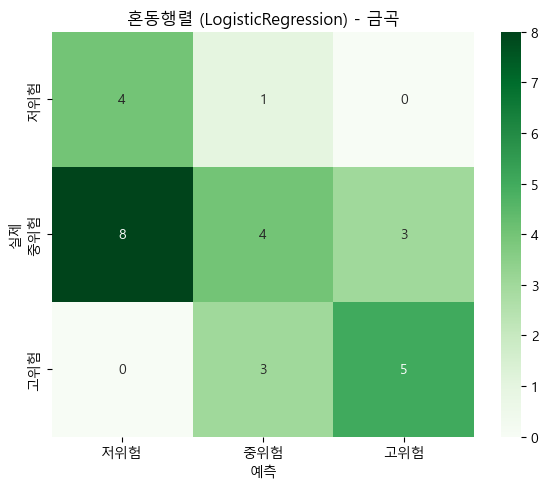


[RandomForest]
               precision    recall  f1-score   support

         고위험       1.00      0.12      0.22         8
         저위험       0.57      0.80      0.67         5
         중위험       0.60      0.80      0.69        15

    accuracy                           0.61        28
   macro avg       0.72      0.58      0.52        28
weighted avg       0.71      0.61      0.55        28



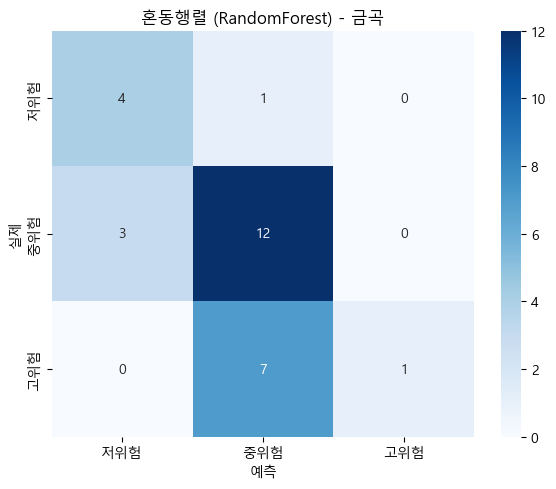


[Final RF] threshold=0.35
               precision    recall  f1-score   support

         고위험       1.00      0.50      0.67         8
         저위험       0.57      0.80      0.67         5
         중위험       0.71      0.80      0.75        15

    accuracy                           0.71        28
   macro avg       0.76      0.70      0.69        28
weighted avg       0.77      0.71      0.71        28



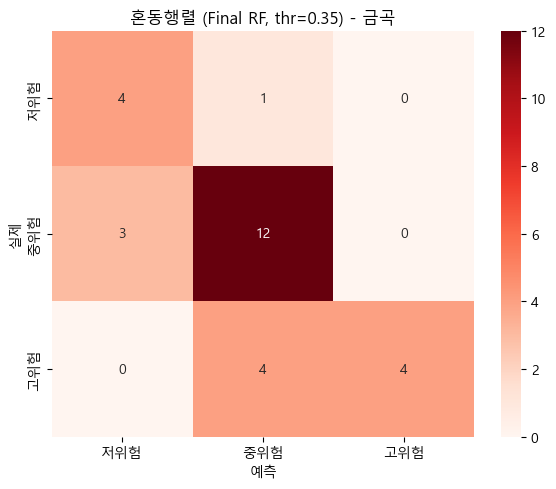


[지점별 모델링] 물금 / test_year=2025
Train n: 190 Test n: 35
Train 연도: [2021, 2022, 2023, 2024]
Test 연도 : [2025]
Test 분포:
 위험도
중위험    15
저위험    11
고위험     9
Name: count, dtype: int64

[LogisticRegression]
               precision    recall  f1-score   support

         고위험       0.71      0.56      0.62         9
         저위험       0.59      0.91      0.71        11
         중위험       0.55      0.40      0.46        15

    accuracy                           0.60        35
   macro avg       0.62      0.62      0.60        35
weighted avg       0.60      0.60      0.58        35



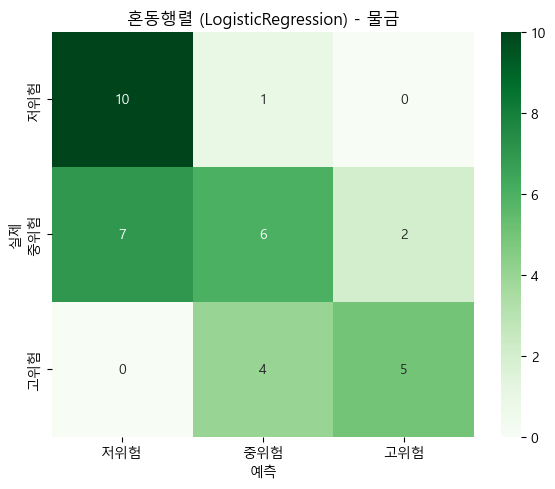


[RandomForest]
               precision    recall  f1-score   support

         고위험       0.67      0.22      0.33         9
         저위험       0.53      0.82      0.64        11
         중위험       0.40      0.40      0.40        15

    accuracy                           0.49        35
   macro avg       0.53      0.48      0.46        35
weighted avg       0.51      0.49      0.46        35



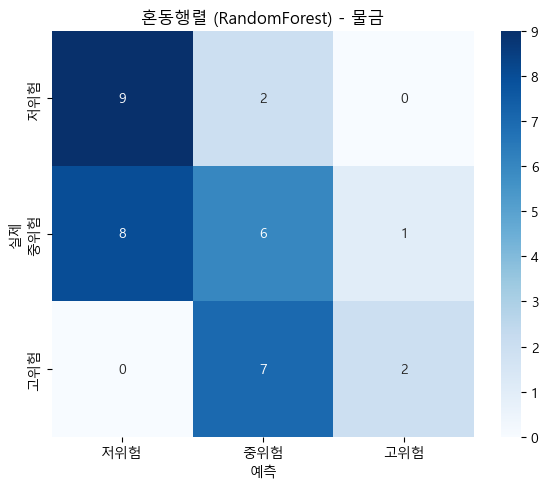


[Final RF] threshold=0.35
               precision    recall  f1-score   support

         고위험       0.78      0.78      0.78         9
         저위험       0.53      0.82      0.64        11
         중위험       0.56      0.33      0.42        15

    accuracy                           0.60        35
   macro avg       0.62      0.64      0.61        35
weighted avg       0.60      0.60      0.58        35



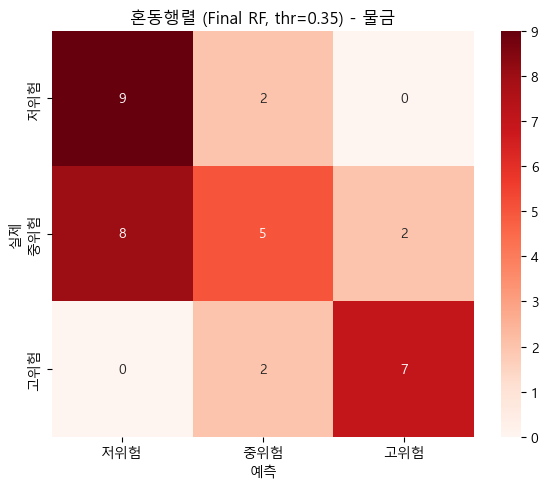

,site,test_year,n_train,n_test
0,금곡,2025,151,28
1,물금,2025,190,35


In [61]:
global_test_year = modelDF['연도'].max()  # 보통 2025

results = []
for site in ['금곡', '물금']:
    out = run_site_model(site, modelDF, test_year=global_test_year, final_threshold=0.35)
    results.append(out)

summaryDF = pd.DataFrame([r for r in results if r is not None])
summaryDF
